In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from my_ANN import (
    initialize_params, forward, compute_cost, backward, update_params, predict, score,
    backward_through_costFunc, backward_through_activation
)

In [2]:
data = scipy.io.loadmat('data.mat')

In [3]:
for i in data.keys():
    if isinstance(data[i], np.ndarray):
        print(i, ':', data[i].shape)
    else:
        print(i)

__header__
__version__
__globals__
X : (211, 2)
y : (211, 1)
yval : (200, 1)
Xval : (200, 2)


In [4]:
train_X, train_Y = data['X'].T, data['y'].T
test_X, test_Y = data['Xval'].T, data['yval'].T

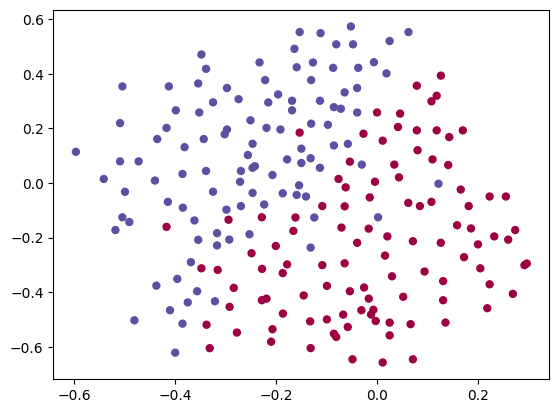

In [5]:
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=25, cmap=plt.cm.Spectral)

# Cost Function with Regularization

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [6]:
def compute_cost_with_Regularization(Y_pred, Y, params, lambda_):
    n_samples = Y.shape[1]
    
    cost = compute_cost(Y_pred, Y)
    L2_regularization_cost = 0

    for i in params.keys():
        if i.startswith('W'):
            L2_regularization_cost += np.sum(np.square(params[i]))
    L2_regularization_cost = (1/(2 * n_samples)) * lambda_ * L2_regularization_cost

    total_cost = cost + L2_regularization_cost
    return total_cost

# Back-Propagation with Regularization

In [7]:
def backward_linearly(dZ, linear_cache, lambda_=0):
    """
    dZ: (n_features_out, n_samples)
    A_prev: (n_features_in, n_samples)
    W: (n_features_out, n_features_in)
    B: (n_features_out, 1)
    """
    A_prev, W, B = linear_cache
    
    n_samples = A_prev.shape[1]
    
    dW = (1/n_samples) * (dZ @ A_prev.T)  + (lambda_/n_samples) * W  # (n_features_out, n_samples) @ (n_samples, n_features_in)
    dB = (1/n_samples) * np.sum(dZ, axis=1, keepdims=True)  # sum all samples each row of (n_features_out, n_samples)
    dA_prev = W.T @ dZ  # (n_features_in, n_features_out) @ (n_features_out, n_samples)

    return dA_prev, dW, dB

In [8]:
def backward_each_layer(dA, cache, activation, lambda_=0):
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = backward_through_activation(dA, activation_cache, activation='relu')
    elif activation == 'sigmoid':
        dZ = backward_through_activation(dA, activation_cache, activation='sigmoid')

    dA_prev, dW, dB = backward_linearly(dZ, linear_cache, lambda_=lambda_)
    
    return dA_prev, dW, dB

In [9]:
def backward_with_Regularization(Y, Y_pred, caches, lambda_=0):  # Y shape (n_samples, )
    grads = {}
    L = len(caches)
    
    Y = Y.reshape(Y_pred.shape)  # Y and Y_pred must have the same shape (1, n_samples)
    dY_pred = backward_through_costFunc(Y, Y_pred, cost_func='binary_cross_entropy')
    
    last_cache = caches[-1]  # cache[L-1]
    dA_prev, dW, dB = backward_each_layer(dY_pred, last_cache, activation='sigmoid', lambda_=lambda_)
    grads[f'dA{L-1}'] = dA_prev
    grads[f'dW{L}'] = dW
    grads[f'dB{L}'] = dB

    for i in range(L-1, 0, -1):  # from L-1 to 1
        dA = dA_prev
        current_cache = caches[i-1]  # from cache[L-2] to cache[0]
        dA_prev, dW, dB = backward_each_layer(dA, current_cache, activation='relu', lambda_=lambda_)
        grads[f'dA{i-1}'] = dA_prev  # to dA0
        grads[f'dW{i}'] = dW
        grads[f'dB{i}'] = dB

    return grads

# Model with Regularization

In [10]:
def my_model(X_train, Y_train, layers, learning_rate=0.01, iterations=1000, lambda_=0):
    costs = []

    np.random.seed(3)
    params = initialize_params(layers)
    
    # training
    for i in range(1, iterations+1):
        # forward pass
        Y_pred, caches = forward(X_train, params)
        # compute cost
        cost = compute_cost_with_Regularization(Y_pred, Y_train, params, lambda_)
        if i % 100 == 0 or i == 1:
            costs.append(cost)
        # backward pass to compute gradients
        grads = backward_with_Regularization(Y_train, Y_pred, caches, lambda_)
        # update parameters
        params = update_params(params, grads, learning_rate)

        # print cost
        if i % 5000 == 0 or i == 1:
            print('Cost after Iteration {}: {}'.format(i, cost))

    return params, costs

In [11]:
def plot_costs(costs, title):
    plt.figure(figsize=(4,3))
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (x100)')
    plt.title(title)
    plt.show()

In [12]:
def plot_decision_boundary(X, y, params):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    """
    x1_min, x1_max = X[0, :].min() - 1, X[0, :].max() + 1
    x2_min, x2_max = X[1, :].min() - 1, X[1, :].max() + 1
    step = 0.01
    
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    
    Y_pred = predict(np.c_[x1.ravel(), x2.ravel()].T, params)  # Y_pred shape (1, -1)
    Y_pred = Y_pred.reshape(x1.shape)
    
    plt.contourf(x1, x2, Y_pred, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral, alpha=0.7)
    plt.show()

# Training

In [13]:
units_each_layer = [train_X.shape[0], 20, 3, 1]

### Without Regularization

In [14]:
params_no_reg, costs_no_reg = my_model(train_X, train_Y, layers=units_each_layer, learning_rate=0.3, iterations=50000)

Cost after Iteration 1: 0.6557412523481002
Cost after Iteration 5000: 0.1768145477227736
Cost after Iteration 10000: 0.1595423109561019
Cost after Iteration 15000: 0.14786598519177635
Cost after Iteration 20000: 0.1446539646942947
Cost after Iteration 25000: 0.1331408761460775
Cost after Iteration 30000: 0.1229308573237206
Cost after Iteration 35000: 0.110801098524962
Cost after Iteration 40000: 0.10415984003389392
Cost after Iteration 45000: 0.10083173250821537
Cost after Iteration 50000: 0.09876056416126248


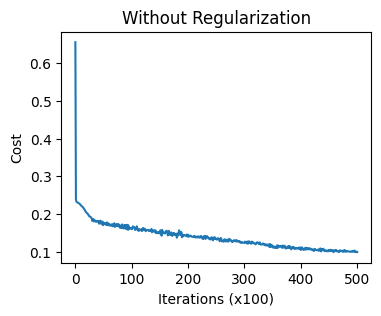

In [15]:
plot_costs(costs_no_reg, title='Without Regularization')

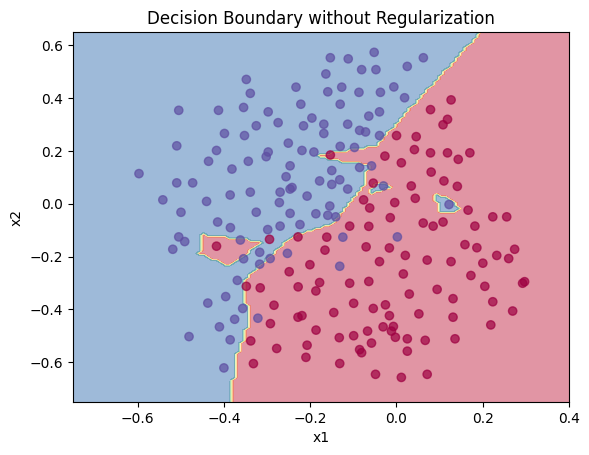

In [16]:
plt.title("Decision Boundary without Regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(train_X, train_Y, params_no_reg)

### With Regulariztion

In [17]:
params_with_reg, costs_with_reg = my_model(train_X, train_Y, layers=units_each_layer, learning_rate=0.3, iterations=50000, lambda_=0.7)

Cost after Iteration 1: 0.6974484493131264
Cost after Iteration 5000: 0.2690784143730685
Cost after Iteration 10000: 0.26852751335396696
Cost after Iteration 15000: 0.2682252252450985
Cost after Iteration 20000: 0.2681151781050506
Cost after Iteration 25000: 0.2679452685458971
Cost after Iteration 30000: 0.26786174287095865
Cost after Iteration 35000: 0.26781798549849556
Cost after Iteration 40000: 0.26785721744367547
Cost after Iteration 45000: 0.26787199835208575
Cost after Iteration 50000: 0.2680443156133493


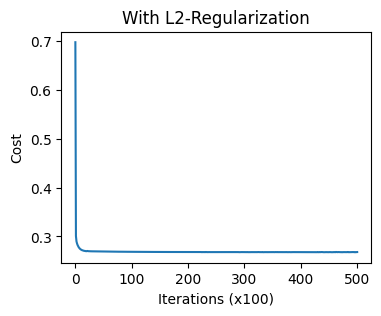

In [18]:
plot_costs(costs_with_reg, title='With L2-Regularization')

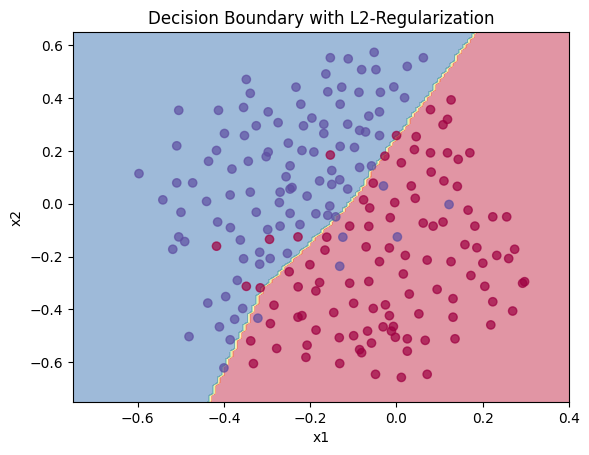

In [19]:
plt.title("Decision Boundary with L2-Regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(train_X, train_Y, params_with_reg)